In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Cell A: imports and quick checks
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Paths
base = '/content/drive/MyDrive/Tomato_dataset/cnn_crops'  # change if needed
ripe_train_dir = os.path.join(base, 'ripe/train')
ripe_val_dir   = os.path.join(base, 'ripe/val')
green_train_dir= os.path.join(base, 'green/train')
green_val_dir  = os.path.join(base, 'green/val')

# Quick helper to print counts
def folder_counts(p):
    out = {}
    for c in sorted(os.listdir(p)):
        cp = os.path.join(p, c)
        if os.path.isdir(cp):
            out[c] = sum([1 for f in os.listdir(cp) if os.path.isfile(os.path.join(cp, f))])
    return out

print("Ripe train counts:", folder_counts(ripe_train_dir))
print("Ripe val counts:  ", folder_counts(ripe_val_dir))
print("Green train counts:", folder_counts(green_train_dir))
print("Green val counts:  ", folder_counts(green_val_dir))

# If you decide to remove 'R_pests' and 'G_pests', do it now (optional)
# Example: os.rename(src, dst) or delete folder content. Be careful!
# e.g.:
# import shutil
# shutil.rmtree('/path/to/R_pests')  # only if you're sure


Ripe train counts: {'R_ber': 62, 'R_healthy': 407, 'R_lateblight': 29, 'R_spots': 189}
Ripe val counts:   {'R_ber': 22, 'R_healthy': 113, 'R_lateblight': 6, 'R_spots': 66}
Green train counts: {'G_ber': 64, 'G_healthy': 1565, 'G_lateblight': 131, 'G_spots': 1038}
Green val counts:   {'G_ber': 29, 'G_healthy': 368, 'G_lateblight': 26, 'G_spots': 302}


In [4]:
# Cell B: create model/training function using MobileNetV2
IMG_SIZE = 160           # smaller for CPU, change to 224 if desired
BATCH_SIZE = 12          # small to fit CPU
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

def make_data_generators(train_dir, val_dir, img_size=IMG_SIZE, batch_size=BATCH_SIZE):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.7,1.3),
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(img_size, img_size),
        batch_size=batch_size, class_mode='categorical', shuffle=True
    )
    val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(img_size, img_size),
        batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    return train_gen, val_gen

def compute_class_weights(generator):
    # generator.classes is the class index for each sample
    classes = generator.classes
    labels = np.unique(classes)
    cw = compute_class_weight(class_weight='balanced', classes=labels, y=classes)
    # return a dict mapping {class_index: weight}
    return {i: cw[i] for i in labels}

def build_transfer_model(num_classes, img_size=IMG_SIZE, base_trainable=False):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False, weights='imagenet', pooling='avg'
    )
    base.trainable = base_trainable  # freeze by default
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = base(inputs, training=False)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def train_with_transfer(train_dir, val_dir, out_path, img_size=IMG_SIZE, batch_size=BATCH_SIZE, epochs=EPOCHS):
    train_gen, val_gen = make_data_generators(train_dir, val_dir, img_size, batch_size)
    num_classes = len(train_gen.class_indices)
    print("Num classes:", num_classes, "Class indices:", train_gen.class_indices)
    class_weights = compute_class_weights(train_gen)
    print("Class weights:", class_weights)

    model = build_transfer_model(num_classes, img_size, base_trainable=False)
    ckpt = ModelCheckpoint(out_path, save_best_only=True, monitor='val_accuracy', mode='max')
    es = EarlyStopping(patience=6, restore_best_weights=True, monitor='val_accuracy')
    rlp = ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss')

    steps_per_epoch = max(1, train_gen.samples // batch_size)
    val_steps = max(1, val_gen.samples // batch_size)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[ckpt, es, rlp],
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        verbose=1
    )

    # Optionally fine-tune: unfreeze last few layers and train with low LR
    base = model.layers[1]  # MobileNetV2 base if you used the builder above - check model.layers
    base.trainable = True
    # freeze all except top N layers
    fine_tune_at = int(len(base.layers) * 0.8)
    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    ft_history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        class_weight=class_weights,
        callbacks=[EarlyStopping(patience=4, restore_best_weights=True), ReduceLROnPlateau(patience=2)],
        steps_per_epoch=steps_per_epoch,
        validation_steps=val_steps,
        verbose=1
    )
    return model, history, ft_history


In [5]:
# Cell C: run training

green_model_path = '/content/drive/MyDrive/Tomato_dataset/models/green_mobilenet.keras'


# Green
_ = train_with_transfer(green_train_dir, green_val_dir, green_model_path)


Found 2798 images belonging to 4 classes.
Found 725 images belonging to 4 classes.
Num classes: 4 Class indices: {'G_ber': 0, 'G_healthy': 1, 'G_lateblight': 2, 'G_spots': 3}
Class weights: {np.int32(0): np.float64(10.9296875), np.int32(1): np.float64(0.44696485623003196), np.int32(2): np.float64(5.3396946564885495), np.int32(3): np.float64(0.6738921001926782)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 587s 2s/step - accuracy: 0.3724 - loss: 2.4121 - val_accuracy: 0.5181 - val_loss: 1.0691 - learning_rate: 0.0010
Epoch 2/30
  1/233 ━━━━━━━━━━━━━━━━━━━━ 44s 194ms/step - accuracy: 0.3333 - loss: 2.6214

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.3333 - loss: 2.6214 - val_accuracy: 0.4944 - val_loss: 1.0943 - learning_rate: 0.0010
Epoch 3/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 100s 431ms/step - accuracy: 0.4506 - loss: 1.2165 - val_accuracy: 0.4903 - val_loss: 1.1160 - learning_rate: 0.0010
Epoch 4/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.5000 - loss: 1.4578 - val_accuracy: 0.4958 - val_loss: 1.1142 - learning_rate: 0.0010
Epoch 5/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 142s 611ms/step - accuracy: 0.5370 - loss: 1.0348 - val_accuracy: 0.5306 - val_loss: 1.1272 - learning_rate: 5.0000e-04
Epoch 6/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.5000 - loss: 1.0605 - val_accuracy: 0.5347 - val_loss: 1.1248 - learning_rate: 5.0000e-04
Epoch 7/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 142s 608ms/step - accuracy: 0.5709 - loss: 0.9981 - val_accuracy: 0.6556 - val_loss: 0.8452 - learning_rate: 5.0000e-04
Epoch 8/30
233/233 ━━━━━━━━━━━━━━━━━━━━ 17s 70ms/step - accuracy: 0.4

In [ ]:
ripe_model_path = '/content/drive/MyDrive/Tomato_dataset/models/ripe_mobilenet.keras'   # prefer .keras
# Ripe
_ = train_with_transfer(ripe_train_dir, ripe_val_dir, ripe_model_path)


🔹 Loading model from: /content/drive/MyDrive/Tomato_dataset/models/green_mobilenet.keras
Found 725 images belonging to 4 classes.
🔹 Evaluating 725 images...
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 840ms/step

✅ Accuracy: 0.6690
✅ F1-score: 0.6805

📊 Classification Report:
              precision    recall  f1-score   support

       G_ber       0.13      0.17      0.15        29
   G_healthy       0.80      0.66      0.73       368
G_lateblight       0.30      0.69      0.42        26
     G_spots       0.68      0.73      0.70       302

    accuracy                           0.67       725
   macro avg       0.48      0.56      0.50       725
weighted avg       0.71      0.67      0.68       725



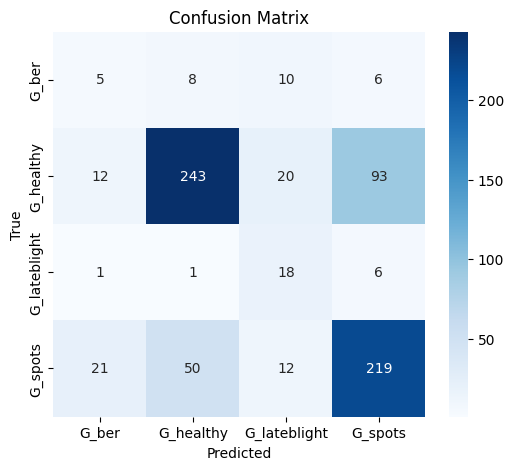

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

def evaluate_model(model_path, data_dir, img_size=(224, 224), batch_size=32):
    print(f"🔹 Loading model from: {model_path}")
    model = load_model(model_path)

    # Load validation data
    datagen = ImageDataGenerator(rescale=1./255)
    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    print(f"🔹 Evaluating {val_gen.samples} images...")
    preds = model.predict(val_gen)
    y_true = val_gen.classes
    y_pred = np.argmax(preds, axis=1)
    class_names = list(val_gen.class_indices.keys())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-score: {f1:.4f}\n")

    print("📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 🧠 Example usage:
evaluate_model(
    "/content/drive/MyDrive/Tomato_dataset/models/green_mobilenet.keras",
    "/content/drive/MyDrive/Tomato_dataset/cnn_crops/green/val",
    img_size=(160, 160)   # ✅ Match model training size
)

